# Attribution methods

In this notebook I perform attribution methods with the Wts and check for correlation with the sign distributions.

In [ ]:
# imports

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

In [ ]:
class CNN2Model_adapted(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(CNN2Model_adapted, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense2 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense3 = tf.keras.layers.Dense(10, activation="softmax",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]

    #@tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        dense1_input = self.flatten(x)
        dense1_out = self.dense1(dense1_input)
        dense2_out = self.dense2(dense1_out)
        dense3_out = self.dense3(dense2_out)
        return dense3_out, dense1_out[0], dense2_out[0]

### Measure and Store Contribution Scores

In [ ]:
def get_connected_neurons(layer):

    indexi = []

    for this_neuron, i in zip(layer.T, range(256)):
        this_unpruned = this_neuron[this_neuron != 0.0]
        # only include neurons that receive input
        if len(this_unpruned) > 0:
                indexi.append(i)

    return indexi
     

In [ ]:
# get contribution values for neurons
def contribution_scores(test, model):

    # hyperparameters
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializeing contribution scores
    c_score_1 = np.zeros(256)
    c_score_2 = np.zeros(256)

    # get the neurons that don't receive input
    indexi_connected_d1 = get_connected_neurons(model.get_weights()[4])

    # iterate through testing set and get gradients for each weight
    for x, t in tqdm(test):

        # get gradients 
        with tf.GradientTape() as tape:
            pred, dense1_out, dense2_out = model(x)
            loss = loss_function(t, pred)
        gradients = tape.gradient(loss, model.trainable_variables)

        # set gradients to zero for all pruned weights
        gradients_dense2 = tf.where(model.trainable_variables[6] == 0.0, 0.0, gradients[6])
        gradients_dense3 = tf.where(model.trainable_variables[8] == 0.0, 0.0, gradients[8])

        # compute c score for each (connected) neuron
        for i in range(256):
            if i in indexi_connected_d1:
                c_score_1[i] = c_score_1[i] + np.sum(np.abs(gradients_dense2[i]*dense1_out[i]))
            #c_score_2[i] = c_score_2[i] + np.sum(np.abs(gradients_dense3[i]*dense2_out[i]))

    # remove c_scores of unconnected neurons
    c_score_1 = [c_score_1[j] for j in indexi_connected_d1]

    # normalize c_scores to values between 0 and 1
    c_score_1 = c_score_1 / np.sum(c_score_1)
    #c_score_2 = c_score_2 / np.sum(c_score_2)
    
    return c_score_1, c_score_2

In [ ]:
# store contribution values for each sign distribution in files
def get_and_store_c_scores(datasets, n_wts):
    train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=2, shuffle_size=512)
    model = CNN2Model_adapted()
    model(list(train_dataset)[0][0])

    for dataset in datasets:
        for i in n_wts:
            train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=1, shuffle_size=512)
            model.load_weights(f"1b WTs/h5_format/WT_{dataset}_IMP_{i}.h5")
            c_scores_1, c_scores_2 = contribution_scores(test_dataset, model)
            np.save(f"5d Contribution values/c_scores_dense1_{dataset}_wt{i}", np.array(c_scores_1))
            #np.save(f"5d Contribution values/c_scores_dense2_{dataset}_wt{i}", np.array(c_scores_2))

In [27]:
# debugging

train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=1, shuffle_size=512)
model = CNN2Model_adapted()
model(list(train_dataset)[0][0])
model.load_weights(f"1b WTs/h5_format/WT_CIFAR_IMP_3.h5")
c_scores_1, c_scores_2 = contribution_scores(test_dataset, model)

sign_distr = pd.read_csv(f'2b Sign distributions/CIFAR_IMP_3_sign_distr.csv')

# combine sign distr and contribution scores
c_scores1 = pd.Series(c_scores_1, name="c_scores")
c_scores2 = pd.Series(c_scores_2, name="c_scores")
c_scores = pd.concat([c_scores1,c_scores2], axis=0)
c_scores= c_scores.reset_index(drop=True)
print("shapes c scores and sign distr: ", c_scores1.shape, sign_distr[sign_distr["layer"]=="dense1"].shape)
sign_distr_combi = pd.concat([sign_distr,c_scores], axis=1)
display(sign_distr_combi)

  3%|▎         | 279/10000 [01:19<47:33,  3.41it/s]

In [26]:
# debugging unconnected neurons

train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=2, shuffle_size=512)
model = CNN2Model_adapted()
model(list(train_dataset)[0][0])

for dataset in ["CIFAR","CINIC","SVHN"]:
    unconnected_statistics = pd.read_csv(f'2b Sign distributions/{dataset}_IMP_unconnected_statistic.csv')
    unconnected_statistics = unconnected_statistics[unconnected_statistics["layer"] == "dense1"]
    for i in range(15):
        model.load_weights(f"1b WTs/h5_format/WT_{dataset}_IMP_{i}.h5")

        # get sign distr and contribution scores
        sign_distr = pd.read_csv(f'2b Sign distributions/{dataset}_IMP_{i}_sign_distr.csv')
        c_scores1 = np.load(f"5d Contribution values/c_scores_dense1_{dataset}_wt{i}.npy")
        #c_scores2 = np.load(f"5d Contribution values/c_scores_dense2_{dataset}_wt{i}.npy")


        shape_unconnected_stats = pd.read_csv(f'2b Sign distributions/{dataset}_IMP_unconnected_statistic.csv')
        shape_unconnected_stats = 256 - shape_unconnected_stats.iloc[i*2]["no_incomming"]
        connected_f = get_connected_neurons(model.get_weights()[4])
        shape_connected_f = len(connected_f)
        shape_sign_distr = sign_distr[sign_distr["layer"] == "dense1"].shape[0]
        shape_c_scores = c_scores1.shape[0]

        # remove neruons with mask
        c_score_z = np.zeros(256)
        c_scores_short = [c_score_z[j] for j in connected_f]
        

        if shape_sign_distr != shape_c_scores:
            print(f"WT{i} for dataset {dataset}: ", "stats = ", shape_unconnected_stats, ", c_scores = ", shape_c_scores)
            print(len(c_scores_short))
        #print("stats: ", shape_unconnected_stats, "func: ", shape_connected_f, "sign_distr: ", shape_sign_distr, "c_scores: ", shape_c_scores)



WT3 for dataset CIFAR:  stats =  238 , c_scores =  237
238
WT4 for dataset CIFAR:  stats =  247 , c_scores =  241
247
WT5 for dataset CIFAR:  stats =  253 , c_scores =  252
253
WT6 for dataset CIFAR:  stats =  248 , c_scores =  246
248
WT8 for dataset CIFAR:  stats =  250 , c_scores =  248
250
WT9 for dataset CIFAR:  stats =  250 , c_scores =  248
250
WT10 for dataset CIFAR:  stats =  249 , c_scores =  245
249
WT14 for dataset CIFAR:  stats =  250 , c_scores =  249
250
WT0 for dataset CINIC:  stats =  202 , c_scores =  199
202
WT4 for dataset CINIC:  stats =  209 , c_scores =  207
209
WT5 for dataset CINIC:  stats =  213 , c_scores =  211
213
WT6 for dataset CINIC:  stats =  212 , c_scores =  211
212
WT7 for dataset CINIC:  stats =  202 , c_scores =  201
202
WT8 for dataset CINIC:  stats =  220 , c_scores =  219
220
WT9 for dataset CINIC:  stats =  215 , c_scores =  210
215
WT10 for dataset CINIC:  stats =  205 , c_scores =  204
205
WT11 for dataset CINIC:  stats =  226 , c_scores =  2

In [ ]:
#get_and_store_c_scores(["CIFAR","CINIC","SVHN"],range(15))
get_and_store_c_scores(["SVHN"],range(15))

### Plot the extracted Contribution scores

,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,c_scores
0,0.913391,0.218750,0.559549,0.480000,0.005806
1,0.891235,0.226562,0.511785,0.515152,0.001856
2,0.890381,0.250000,0.522272,0.421875,0.002640
3,0.916016,0.320312,0.549419,0.574713,0.002388
4,0.949463,0.355469,0.485507,0.521212,0.000346
...,...,...,...,...,...
237,0.921570,0.242188,0.502724,0.500000,0.000046
238,0.920105,0.175781,0.561497,0.559242,0.011718
239,0.930908,0.183594,0.582155,0.526316,0.005980
240,0.909180,0.281250,0.475134,0.505435,0.000468


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,c_scores
242,0.203125,0.1,0.514706,0.666667,8.510382e-04
243,0.273438,0.4,0.505376,0.500000,5.755656e-04
244,0.281250,0.1,0.456522,0.555556,4.370024e-03
245,0.304688,0.4,0.567416,0.500000,6.402322e-04
246,0.339844,0.3,0.568047,0.142857,2.306584e-04
...,...,...,...,...,...
237,NaN,NaN,NaN,NaN,9.461779e-04
238,NaN,NaN,NaN,NaN,2.938436e-04
239,NaN,NaN,NaN,NaN,9.726615e-08
240,NaN,NaN,NaN,NaN,2.362234e-03


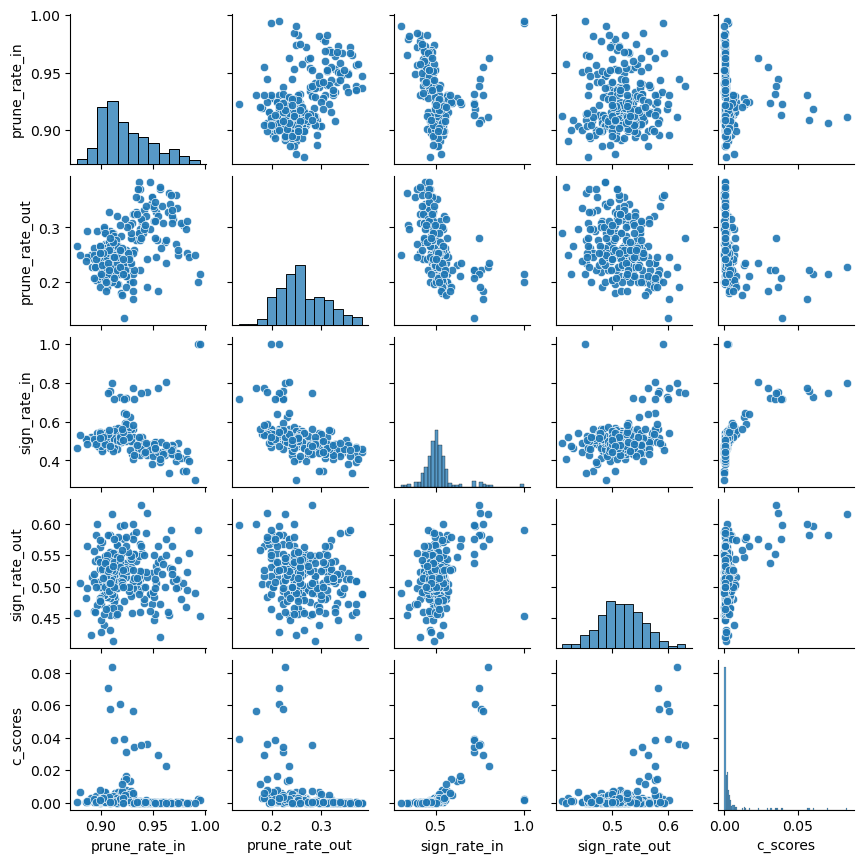

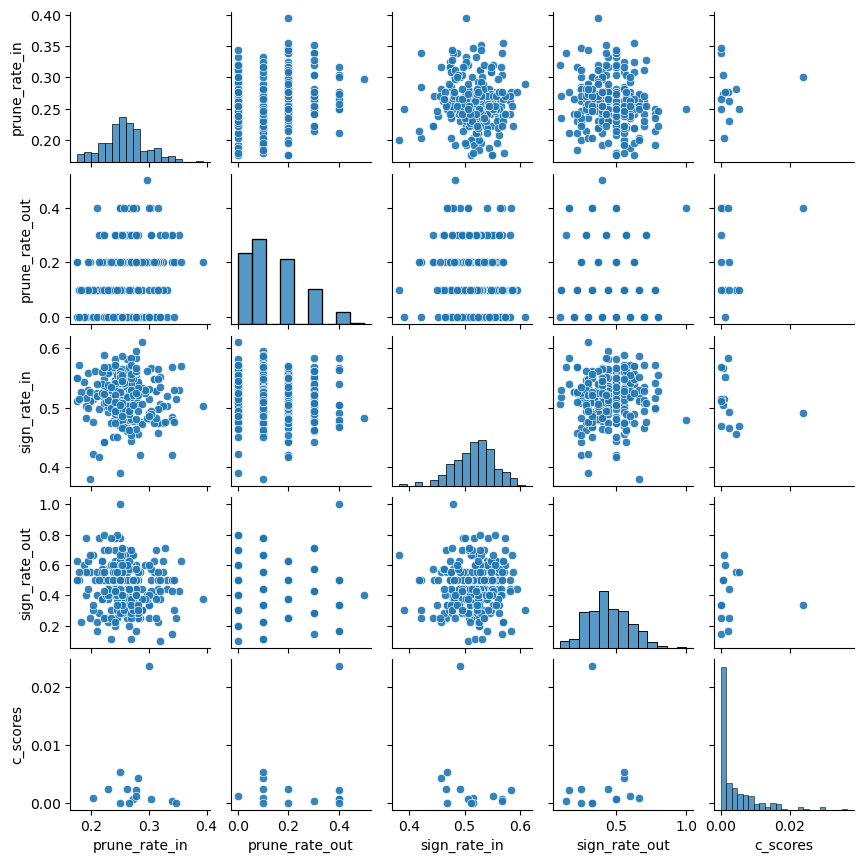

In [18]:
# plot contribution values in scatterplot matrix as 5th dimension

c_scores1 = np.load("5d Contribution values/c_scores_dense1_CIFAR_wt0.npy")
c_scores2 = np.load("5d Contribution values/c_scores_dense2_CIFAR_wt0.npy")
c_scores1 = pd.Series(c_scores1, name="c_scores")
c_scores2 = pd.Series(c_scores2, name="c_scores")

sign_distr = pd.read_csv(f'2b Sign distributions/CIFAR_IMP_0_sign_distr.csv')
sign_distr1 = sign_distr[sign_distr["layer"] == "dense1"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
sign_distr2 = sign_distr[sign_distr["layer"] == "dense2"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]

sign_distr_combi1 = pd.concat([sign_distr1,c_scores1], axis=1)
sign_distr_combi2 = pd.concat([sign_distr2,c_scores2], axis=1)
display(sign_distr_combi1)
display(sign_distr_combi2)


sns.pairplot(sign_distr_combi1, height=1.75, kind='scatter', plot_kws={'alpha':0.9}) #.savefig(f"3b Plots/{name}_dense1_all_sign_distr.png")
sns.pairplot(sign_distr_combi2, height=1.75, kind='scatter', plot_kws={'alpha':0.9})

In [22]:
# collect statistics for contribution value of each cluster

def get_collective_combined_sign_distr(n, dataset):

    # collect all the sign distributions in one huge dataFrame
    coll_sign_distr = pd.DataFrame()
    for i in range(n):

        # get sign distr and contribution scores
        sign_distr = pd.read_csv(f'2b Sign distributions/{dataset}_IMP_{i}_sign_distr.csv')
        c_scores1 = np.load(f"5d Contribution values/c_scores_dense1_{dataset}_wt{i}.npy")
        c_scores2 = np.load(f"5d Contribution values/c_scores_dense2_{dataset}_wt{i}.npy")

        # combine sign distr and contribution scores
        c_scores1 = pd.Series(c_scores1, name="c_scores")
        c_scores2 = pd.Series(c_scores2, name="c_scores")
        c_scores = pd.concat([c_scores1,c_scores2], axis=0)
        c_scores= c_scores.reset_index(drop=True)
        print("shapes c scores and sign distr: ", c_scores1.shape, sign_distr[sign_distr["layer"]=="dense1"].shape)
        sign_distr_combi = pd.concat([sign_distr,c_scores], axis=1)

        # add to collective sign distr
        coll_sign_distr = pd.concat([coll_sign_distr, sign_distr_combi])

    display(coll_sign_distr)

    # seperate the dataframe by layer
    coll_sign_distr_layer1 = coll_sign_distr[coll_sign_distr["layer"]=="dense1"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out", "c_scores"]]
    coll_sign_distr_layer2 = coll_sign_distr[coll_sign_distr["layer"]=="dense2"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out", "c_scores"]]

    # make and store one plot for each layer
    sns.pairplot(coll_sign_distr_layer1, height=1.75, kind='scatter', plot_kws={'alpha':0.075})#.savefig(f"5d Contribution scores/{dataset}_dense1_all_sign_distr_combi.png")
    sns.pairplot(coll_sign_distr_layer2, height=1.75, kind='scatter', plot_kws={'alpha':0.075})#.savefig(f"5d Contribution scores/{dataset}_dense2_all_sign_distr_combi.png")


shapes c scores and sign distr:  (242,) (242, 9)
shapes c scores and sign distr:  (242,) (242, 9)
shapes c scores and sign distr:  (236,) (236, 9)
shapes c scores and sign distr:  (237,) (238, 9)
shapes c scores and sign distr:  (241,) (247, 9)
shapes c scores and sign distr:  (252,) (253, 9)
shapes c scores and sign distr:  (246,) (248, 9)
shapes c scores and sign distr:  (246,) (246, 9)
shapes c scores and sign distr:  (248,) (250, 9)
shapes c scores and sign distr:  (248,) (250, 9)
shapes c scores and sign distr:  (245,) (249, 9)
shapes c scores and sign distr:  (252,) (252, 9)
shapes c scores and sign distr:  (242,) (242, 9)
shapes c scores and sign distr:  (236,) (236, 9)
shapes c scores and sign distr:  (249,) (250, 9)


,pos_in,pos_out,neg_in,neg_out,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,layer,c_scores
0,794,96,625,104,0.913391,0.218750,0.559549,0.480000,dense1,0.005806
1,912,102,870,96,0.891235,0.226562,0.511785,0.515152,dense1,0.001856
2,938,81,858,111,0.890381,0.250000,0.522272,0.421875,dense1,0.002640
3,756,100,620,74,0.916016,0.320312,0.549419,0.574713,dense1,0.002388
4,402,86,426,79,0.949463,0.355469,0.485507,0.521212,dense1,0.000346
...,...,...,...,...,...,...,...,...,...,...
501,95,5,90,3,0.277344,0.200000,0.513514,0.625000,dense2,0.001933
502,100,4,81,3,0.292969,0.300000,0.552486,0.571429,dense2,0.005603
503,95,4,94,5,0.261719,0.100000,0.502646,0.444444,dense2,0.004879
504,86,4,90,4,0.312500,0.200000,0.488636,0.500000,dense2,0.002249


ValueError: cannot reindex on an axis with duplicate labels

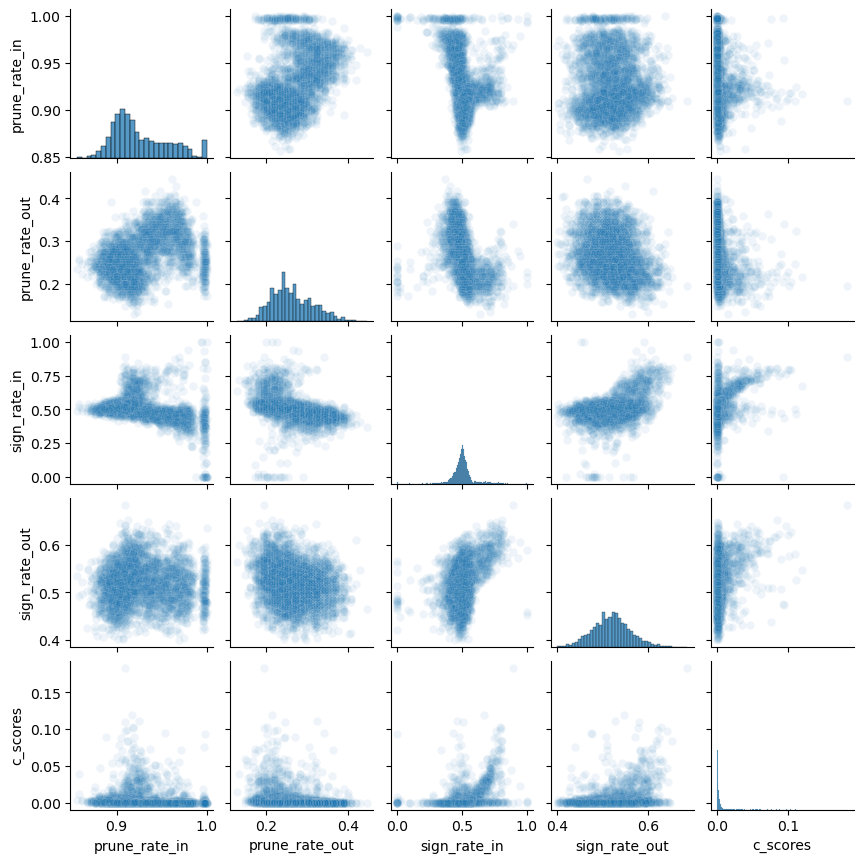

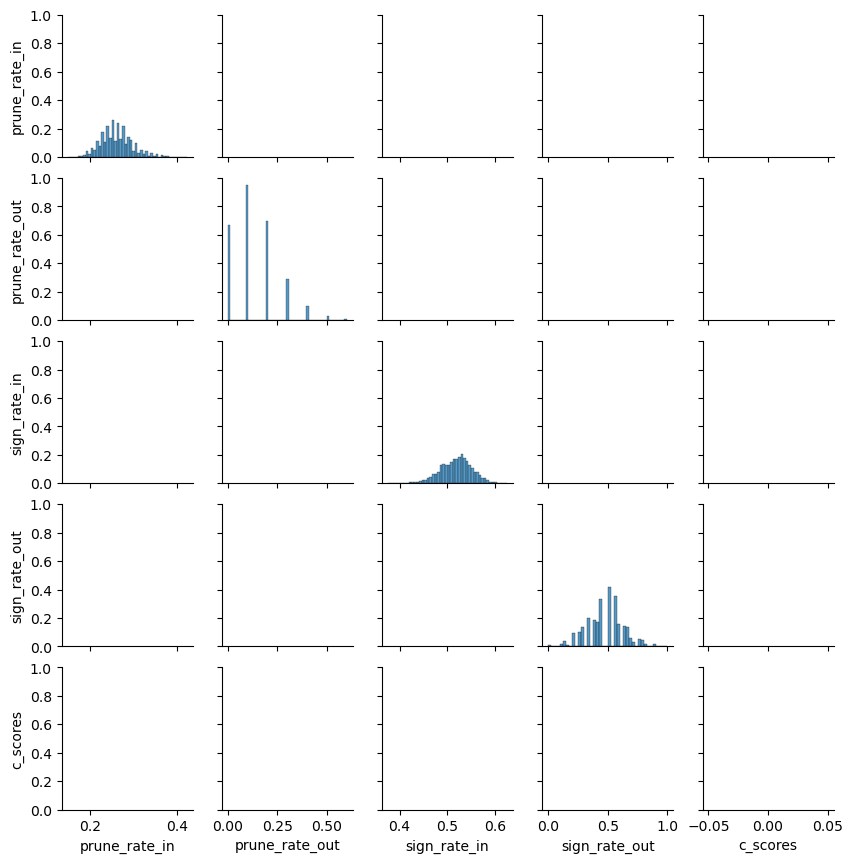

In [23]:
get_collective_combined_sign_distr(15, "CIFAR")